In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Patch as mpatch
from matplotlib.lines import Line2D as mline
import seaborn as sns

In [2]:
plt.style.use("seaborn")
sns.set_context("talk")
style_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
results = {
    i:pd.read_pickle(f"../basin_output_no_ints/{i}.pickle") for i in [
        "lower_col", "upper_col", "missouri", "pnw"
    ]
}

In [4]:
def combine_res_metrics(results):
    output = pd.DataFrame(columns=["site_name", "basin", "group", "metric", "value"])
    for basin, values in results.items():
        for group, data in values.items():
            metrics = data["metrics"].reset_index().rename(
                columns={"index":"site_name"}
            )
            try:
                # need to convert from cudf to pddf if needed
                metrics = metrics.to_pandas()
            except AttributeError as e:
                pass
            metrics = metrics.melt(id_vars=["site_name"], var_name="metric")
            metrics["basin"] = basin
            metrics["group"] = group
            output = pd.concat([output, metrics])
    return output

In [5]:
def get_mean_release(results):
    output = pd.Series(dtype=np.float64)
    for basin, values in results.items():
        for group, data in values.items():
            act = data["eval_data"]["actual"]
            means = act.groupby(act.index.get_level_values(0)).mean()
            try:
                # need to convert from cudf to pddf if needed
                means = means.to_pandas()
            except AttributeError as e:
                pass
            output = output.append(means)
    return output

In [6]:
metrics = combine_res_metrics(results)

In [7]:
mean_release = get_mean_release(results)

In [8]:
for res, value in mean_release.items():
    metrics.loc[
        (metrics["site_name"] == res) & (metrics["metric"] == "rmse"), "value"
    ] *= 100 / value

In [9]:
# replace pnw loc names
with open("../../pnw_data/meta_data/dam_abbrs.json", "r") as f:
    abbrs = json.load(f)
    
metrics["site_name"] = [abbrs.get(i)["name"] if i in abbrs else i for i in metrics["site_name"]]

In [10]:
# replace missouri names
mis_meta = pd.read_csv("../../missouri_data/hydromet_stations.csv")
names = []
for i in metrics["site_name"]:
    name = mis_meta.loc[mis_meta["ID"] == i, "Name"].str.split(",", expand=True).values
    if len(name) == 0:
        names.append(i)
    else:
        names.append(name[0][0])
metrics["site_name"] = names

In [11]:
metrics["site_name"] = metrics["site_name"].str.title()
metrics["site_name"] = metrics["site_name"].replace("Angostura Reservoir (Cheyenne River Blw Dam)", "Angostura Reservoir")
metrics["site_name"] = metrics["site_name"].str.replace("( Reservoir)|( Dam)", "", regex=True)

In [12]:
drop_res = ["Grand Coulee", "Brownlee", "Parker"]

In [13]:
plot_scores = metrics.loc[
    (metrics["metric"] == "r2_score") & ~(metrics["site_name"].isin(drop_res))
]

plot_rmse = metrics.loc[
    (metrics["metric"] == "rmse") & ~(metrics["site_name"].isin(drop_res))
]

In [14]:
basin_colors = {j:style_colors[i] for i,j in enumerate(["upper_col", "lower_col", "pnw", "missouri"])}
basin_hatch = {
    "upper_col":"/",
    "lower_col":"--",
    "pnw":"x",
    "missouri":"+"
}
group_hatch = {
    "high_rt":"/",
    "low_rt":"x",
    "ror":"--"
}

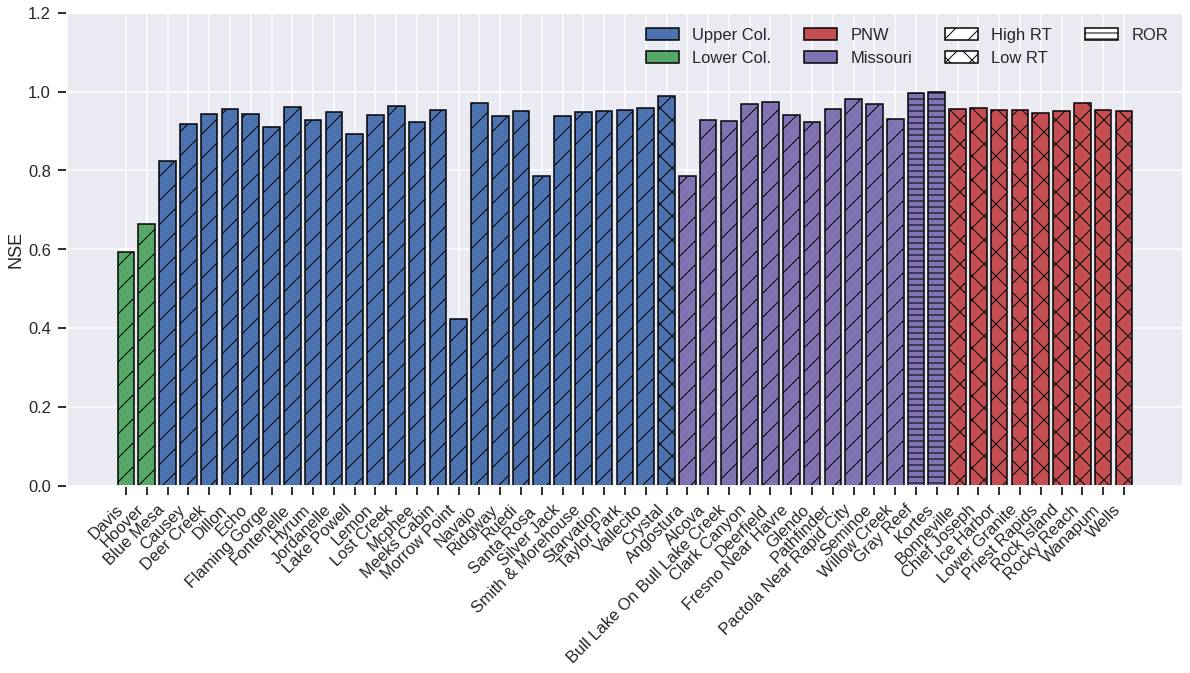

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20,8.7))
colors = [basin_colors[i] for i in plot_scores["basin"]]
hatchs = [group_hatch[i] for i in plot_scores["group"]]
ax.bar(plot_scores["site_name"], plot_scores["value"], edgecolor="k", color=colors, hatch=hatchs)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(plot_scores["site_name"], ha="right", rotation=45)
handles = [
    mpatch(facecolor=basin_colors["upper_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["lower_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["pnw"], edgecolor="k"),
    mpatch(facecolor=basin_colors["missouri"], edgecolor="k"),
    mpatch(facecolor="w", edgecolor="k", hatch="/"),
    mpatch(facecolor="w", edgecolor="k", hatch="x"),
    mpatch(facecolor="w", edgecolor="k", hatch="--")
]
labels = ["Upper Col.", "Lower Col.", "PNW", "Missouri", "High RT", "Low RT", "ROR"]
ax.set_ylim(0, 1.2)
ax.legend(handles, labels, loc="best", ncol=4)
ax.set_ylabel("NSE")
plt.show()

In [16]:
import glob
def combine_res_meta():
    files = glob.glob(f"../basin_output_no_ints/*_meta.pickle")
    metas = [pd.read_pickle(f) for f in files]
    for i, m in enumerate(metas):
        try:
            metas[i] = m.to_pandas()
        except AttributeError as e:
            pass
    return pd.concat(metas, axis=0, ignore_index=False)

In [17]:
meta = combine_res_meta()

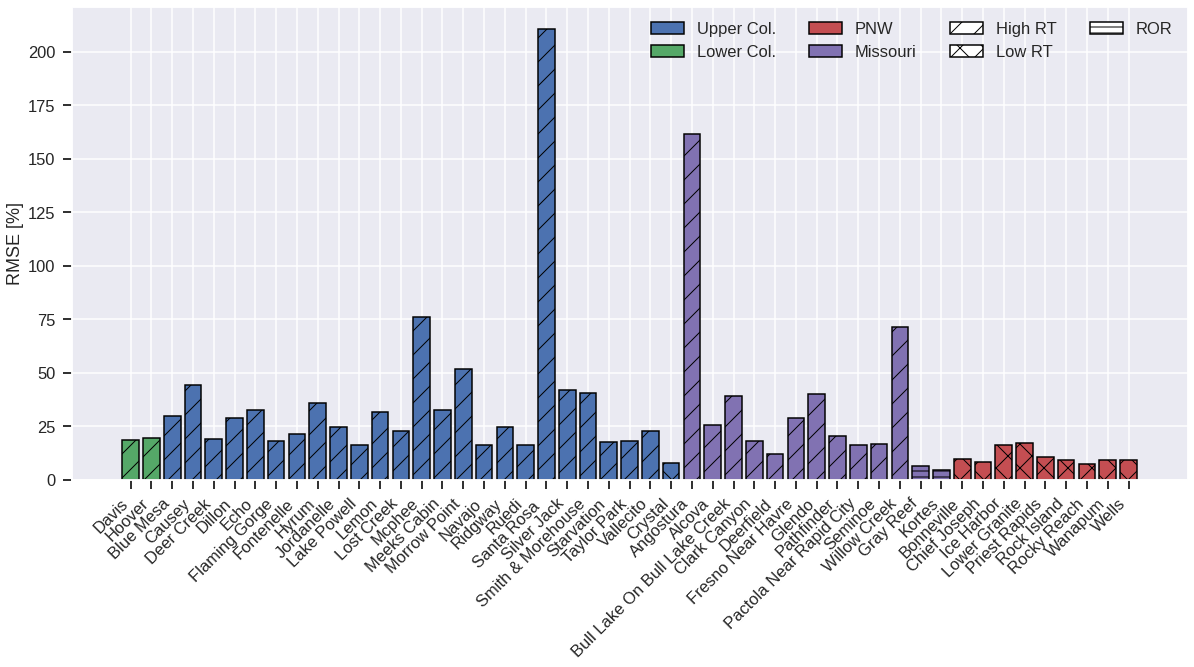

In [18]:
fig, ax = plt.subplots(1,1,figsize=(20,8.7))
colors = [basin_colors[i] for i in plot_rmse["basin"]]
hatchs = [group_hatch[i] for i in plot_rmse["group"]]
ax.bar(plot_rmse["site_name"], plot_rmse["value"], edgecolor="k", color=colors, hatch=hatchs)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(plot_rmse["site_name"], ha="right", rotation=45)
handles = [
    mpatch(facecolor=basin_colors["upper_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["lower_col"], edgecolor="k"),
    mpatch(facecolor=basin_colors["pnw"], edgecolor="k"),
    mpatch(facecolor=basin_colors["missouri"], edgecolor="k"),
    mpatch(facecolor="w", edgecolor="k", hatch="/"),
    mpatch(facecolor="w", edgecolor="k", hatch="x"),
    mpatch(facecolor="w", edgecolor="k", hatch="--")
]
labels = ["Upper Col.", "Lower Col.", "PNW", "Missouri", "High RT", "Low RT", "ROR"]
# ax.set_ylim(0, 1.2)
ax.legend(handles, labels, loc="best", ncol=4)
ax.set_ylabel("RMSE [%]")
plt.show()

In [24]:
metrics.loc[metrics.site_name.isin(drop_res)]

,site_name,basin,group,metric,value
2,Parker,lower_col,high_rt,r2_score,-5.295694
5,Parker,lower_col,high_rt,rmse,87.337257
0,Brownlee,pnw,high_rt,r2_score,-9.743977
1,Grand Coulee,pnw,high_rt,r2_score,-12.908287
2,Brownlee,pnw,high_rt,rmse,218.307333
3,Grand Coulee,pnw,high_rt,rmse,144.924690


In [20]:
# current ror reservoirs
meta[(meta["rel_inf_corr"] > 0.95) & (meta["max_sto"] < 10)]

,rts,rel_inf_corr,max_sto,group
site_name,,,,
GRAR,1.182952,0.998254,1.860,ror
KORR,3.785957,0.999829,5.595,ror


In [21]:
# possible ror reservoirs
meta[meta["rel_inf_corr"] > 0.95]
# a ton of low_rt reservoirs could be considered ROR if we drop the 10000 acre-feet storage requirement

,rts,rel_inf_corr,max_sto,group
site_name,,,,
CRYSTAL,10.525296,0.990221,20.097,low_rt
BON,3.703203,0.996836,764.200,low_rt
CHJ,5.370152,0.995557,589.200,low_rt
IHR,7.725283,0.998876,414.100,low_rt
LWG,9.089483,0.998465,482.143,low_rt
PRD,0.267596,0.995518,44.171,low_rt
RIS,0.090411,0.997494,11.600,low_rt
RRH,0.249768,0.994989,39.960,low_rt
WAN,1.041741,0.993349,167.150,low_rt


In [22]:
# possible ror reservoirs if bump up to 0.99
meta[meta["rel_inf_corr"] > 0.99]

,rts,rel_inf_corr,max_sto,group
site_name,,,,
CRYSTAL,10.525296,0.990221,20.097,low_rt
BON,3.703203,0.996836,764.200,low_rt
CHJ,5.370152,0.995557,589.200,low_rt
IHR,7.725283,0.998876,414.100,low_rt
LWG,9.089483,0.998465,482.143,low_rt
PRD,0.267596,0.995518,44.171,low_rt
RIS,0.090411,0.997494,11.600,low_rt
RRH,0.249768,0.994989,39.960,low_rt
WAN,1.041741,0.993349,167.150,low_rt
